In [84]:
from IPython.core.display import display, HTML
from IPython.display import display
display(HTML("<style>.container { width:100% !important; }</style>"))

In [83]:
import yfinance as yf
import pandas as pd
#import garch
import datetime
import warnings
import investpy
import statistics
import numpy as np
import matplotlib.pyplot as plt
import arch
from arch import arch_model
warnings.simplefilter('ignore')    

In [59]:
import arch
#import holidays
import pmdarima
import pandas as pd
import numpy as np
from pandas import Series, DataFrame
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from datetime import datetime
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.stattools import adfuller, coint
from statsmodels.tsa.vector_ar.vecm import VECM
from sklearn import preprocessing
%matplotlib inline

# 1. Data importing

In [60]:
##Gold, Equity ETF, and Bitcoin data importing for full 2020##
gold_2020_df = investpy.get_etf_historical_data(etf='Perth Mint Physical Gold', country='United States', from_date='01/01/2020', to_date='31/12/2020')
equity_2020_df = investpy.get_etf_historical_data(etf='Vanguard FTSE Developed Markets', country='United States', from_date='01/01/2020', to_date='31/12/2020')
bitcoin_2020_df = investpy.get_crypto_historical_data(crypto='bitcoin', from_date='01/01/2020', to_date='31/12/2020')

##Gold, equity and bitcoin prices for Apr-Dec 2020##
gold_df = investpy.get_etf_historical_data(etf='Perth Mint Physical Gold', country='United States', from_date='01/04/2020', to_date='31/12/2020')
gold_df['Date1'] = gold_df.index
equity_df = investpy.get_etf_historical_data(etf='Vanguard FTSE Developed Markets', country='United States', from_date='01/04/2020', to_date='31/12/2020')
equity_df['Date1'] = equity_df.index
bitcoin_df = investpy.get_crypto_historical_data(crypto='bitcoin', from_date='01/04/2020', to_date='31/12/2020')
bitcoin_df['Date1'] = bitcoin_df.index

In [61]:
missing = set(equity_2020_df.index) - set(gold_2020_df.index)
def remove_missing_days(df, indices, missing):
    return df.loc[[index for index in indices if index not in missing]]

In [62]:
gold_2020_df = remove_missing_days(gold_2020_df, equity_2020_df.index, missing)
equity_2020_df = remove_missing_days(equity_2020_df, equity_2020_df.index, missing)
bitcoin_2020_df = remove_missing_days(bitcoin_2020_df, equity_2020_df.index, missing)

In [63]:
assert equity_2020_df.shape == gold_2020_df.shape
assert equity_2020_df.shape == bitcoin_2020_df.shape

AssertionError: 

In [64]:
equity_2020_df = equity_2020_df.ffill()

In [65]:
gold_2020_df["Daily Return"] = gold_2020_df["Close"].pct_change(1)
equity_2020_df["Daily Return"] = equity_2020_df["Close"].pct_change(1)
bitcoin_2020_df["Daily Return"] = bitcoin_2020_df["Close"].pct_change(1)

# 2. Data processing

In [66]:
##Gold, equity and bitcoin returns calculation##
gold_df['return'] = gold_df['Close'].pct_change(periods=1)
equity_df['return'] = equity_df['Close'].pct_change(periods=1)
bitcoin_df['return'] = bitcoin_df['Close'].pct_change(periods=1)

# 3. Data summaries

In [67]:
# return the kurtosis
# skip the missing values
kurt_gold = gold_df['return'].kurtosis(skipna = True)
kurt_equity = equity_df['return'].kurtosis(skipna = True)
kurt_bitcoin = bitcoin_df['return'].kurtosis(skipna = True)
print(kurt_gold, kurt_equity, kurt_bitcoin)

4.729732844442619 2.9485276225437156 2.796264906407601


#### 3.3 calculating number of extreme values outside the (mean +- 3-sigma) range to select 2 series

In [68]:
std_gold = gold_df['return'].std(skipna = True)
std_equity = equity_df['return'].std(skipna = True)
std_bitcoin = bitcoin_df['return'].std(skipna = True)
mean_gold = gold_df['return'].mean(skipna = True)
mean_equity = equity_df['return'].mean(skipna = True)
mean_bitcoin = bitcoin_df['return'].mean(skipna = True)

In [69]:
number_gold = 0
for it in gold_df['return']:
        if (it < (mean_gold-3*std_gold)):
            number_gold += 1
        elif (it > (mean_gold+3*std_gold)):
            number_gold += 1

number_equity = 0
for it in equity_df['return']:
        if (it < (mean_equity-3*std_equity)):
            number_equity += 1
        elif (it > (mean_equity+3*std_equity)):
            number_equity += 1
            
number_bitcoin = 0
for it in bitcoin_df['return']:
        if (it < (mean_bitcoin-3*std_bitcoin)):
            number_bitcoin += 1
        elif (it > (mean_bitcoin+3*std_bitcoin)):
            number_bitcoin += 1
print(number_gold, number_equity, number_bitcoin)

3 3 6


##### Given the result, we are choosing gold and bitcoin series for further analysis

# 4. Data comparison. Copulas

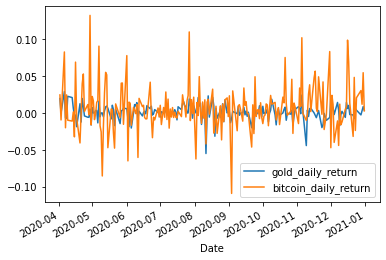

In [70]:
#plotting returns of bitcoin and gold for Apr-Dec
combined_returns_df = pd.DataFrame()
combined_returns_df['gold_daily_return'] = gold_df['return']
combined_returns_df['bitcoin_daily_return'] = bitcoin_df['return']
combined_returns_df.plot()
combined_returns_df = combined_returns_df.iloc[1:]

In [71]:
import copula
import ambhas
from copulalib.copulalib import Copula
## Using the Gumbel

In [72]:
def generateCopulas():
    #global x,y
    fig = plt.figure()
    gumbel = Copula(combined_returns_df['gold_daily_return'],combined_returns_df['bitcoin_daily_return'],family='gumbel')
    ug,vg = gumbel.generate_uv(200)
    #fig.add_subplot(2,2,3)
    plt.scatter(ug,vg,marker='.',color='green')
    #plt.ylim(0,1)
    #plt.xlim(0,1)
    plt.title('Gumbel copula')
    plt.show()
############################################
def plotData():
    #global x,y
    fig = plt.figure()
    fig.add_subplot(2,2,1)
    plt.hist(combined_returns_df['gold_daily_return'],bins=20,color='green',alpha=0.8,align='mid')
    plt.title('Gold ETF distribution')
    fig.add_subplot(2,2,3)
    plt.scatter(combined_returns_df['gold_daily_return'],combined_returns_df['bitcoin_daily_return'],marker="o",alpha=0.8)
    fig.add_subplot(2,2,4)
    plt.title('Joint Gold and Bitcoin')
    plt.hist(combined_returns_df['bitcoin_daily_return'],bins=20,orientation='horizontal',color='red',alpha=0.8,align='mid')
    plt.title('Bitcion ETF distribution')    
    plt.show()


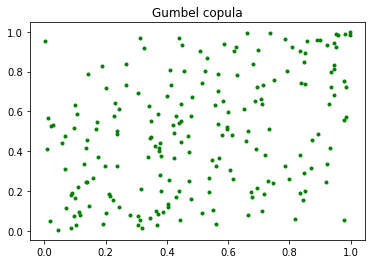

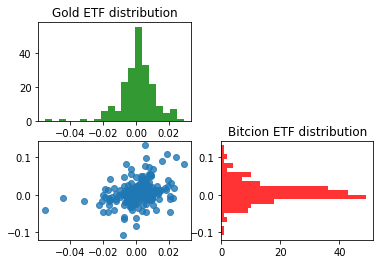

In [73]:
generateCopulas()
plotData()

## 5. Category 1 Models: Just use 1 variable.  Note that Q represents QUARTER, not question.

In [74]:
import matplotlib.pyplot as plt
import datetime 
from datetime import date
from datetime import timedelta
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima.model import ARIMA
register_matplotlib_converters()
from time import time

In [75]:
## seperating the quarterly data 
q2_start_date = datetime.date(2020, 4, 1)
q3_start_date = datetime.date(2020, 7, 1)
q4_start_date = datetime.date(2020, 10, 1)
q4_end_date = datetime.date(2020, 12, 31)

gold_df['Date2'] = pd.to_datetime(gold_df['Date1']).dt.date
gold_df_Q2 = gold_df.loc[(gold_df['Date2'] >= q2_start_date) & (gold_df['Date2'] < q3_start_date)]
close_Q2 = gold_df_Q2['Close'].dropna()
gold_df_Q3 = gold_df.loc[(gold_df['Date2'] >= q3_start_date) & (gold_df['Date2'] < q4_start_date)]
close_Q3 = gold_df_Q3['Close'].dropna()
gold_df_Q4 = gold_df.loc[(gold_df['Date2'] >= q4_start_date) & (gold_df['Date2'] <= q4_end_date)]
close_Q4 = gold_df_Q4['Close'].dropna()

In [76]:
def get_data(df, month_start, month_end, column):
    return df[(df.index >= f"2020-{month_start:02d}-01") & (df.index < f"2020-{month_end:02d}-01")][column]

def fit_arima(data, exog= None):
    model = ARIMA(data, exog=exog, order=(1,0,1))
    model_fit = model.fit()
    print(model_fit.summary())
    return model_fit

In [77]:
gold_q2 = get_data(gold_2020_df, 4, 6, "Daily Return")
equity_q2 = get_data(equity_2020_df, 4, 6, "Daily Return")
bitcoin_q2 = get_data(bitcoin_2020_df, 4, 6, "Daily Return")

gold_q3 = get_data(gold_2020_df, 7, 9, "Daily Return")
equity_q3 = get_data(equity_2020_df, 7, 9, "Daily Return")
bitcoin_q3 = get_data(bitcoin_2020_df, 7, 9, "Daily Return")

gold_q4 = get_data(gold_2020_df, 10, 12, "Daily Return")
equity_q4 = get_data(equity_2020_df, 10, 12, "Daily Return")
bitcoin_q4 = get_data(bitcoin_2020_df, 10, 12, "Daily Return")

In [78]:
model = fit_arima(bitcoin_q2)
return_pred = model.predict(start=bitcoin_q2.shape[0], end=bitcoin_q2.shape[0] + bitcoin_q3.shape[0] - 1).values
signal = np.where(return_pred > 0, 1, -1)
return_q3 = np.product(bitcoin_q3 * signal + 1) - 1
return_q3

                               SARIMAX Results                                
Dep. Variable:           Daily Return   No. Observations:                   43
Model:                 ARIMA(1, 0, 1)   Log Likelihood                  74.775
Date:                Tue, 26 Oct 2021   AIC                           -141.549
Time:                        18:29:05   BIC                           -134.504
Sample:                             0   HQIC                          -138.951
                                 - 43                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0107      0.003      3.217      0.001       0.004       0.017
ar.L1          0.7675      0.246      3.122      0.002       0.286       1.249
ma.L1         -0.9887      0.737     -1.341      0.1

0.2746239901920007

In [79]:
model = fit_arima(bitcoin_q3)
return_pred = model.predict(start=bitcoin_q3.shape[0], end=bitcoin_q3.shape[0] + bitcoin_q4.shape[0] - 1).values
signal = np.where(return_pred >0, 1, -1)
return_q4 = np.product(bitcoin_q4 * signal + 1) - 1
return_q4

                               SARIMAX Results                                
Dep. Variable:           Daily Return   No. Observations:                   54
Model:                 ARIMA(1, 0, 1)   Log Likelihood                 128.817
Date:                Tue, 26 Oct 2021   AIC                           -249.634
Time:                        18:29:05   BIC                           -241.678
Sample:                             0   HQIC                          -246.566
                                 - 54                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0047      0.004      1.334      0.182      -0.002       0.012
ar.L1         -0.7535      0.404     -1.865      0.062      -1.545       0.038
ma.L1          0.5899      0.488      1.209      0.2

0.8279433190115155

In [80]:
(1 + return_q3) * (1 + return_q4) - 1

1.3299404071232672

We prefer the ARMA model for the ease of model and a decent return

#### GARCH model for Q2 and Q3 data

In [81]:
train_garch = gold_df_Q2['return'].dropna()
test_garch = gold_df_Q3['return'].dropna()

Iteration:      1,   Func. Count:     32,   Neg. LLF: -213.00575022701113
Optimization terminated successfully    (Exit mode 0)
            Current function value: -213.00575033918756
            Iterations: 5
            Function evaluations: 32
            Gradient evaluations: 1


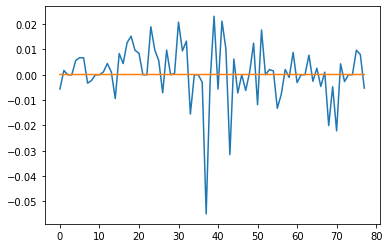

In [82]:

from matplotlib import pyplot
from arch import arch_model
model = arch_model(train_garch, mean='Zero', vol='GARCH', p=15, q=15)
# fit model
model_fit = model.fit()
# forecast the test set
yhat = model_fit.forecast(horizon=len(test_garch))
tes_garch = pd.DataFrame({'date':test_garch.index, 'values':test_garch.values})
pyplot.plot(tes_garch['values'])
pyplot.plot(yhat.variance.values[-1, :])
pyplot.show()

## 6. Category 2 Models: Just use 2 variables: the one you are trading, and an additional (called exogeneous variable) to enhance prediction


#### VARMA model 

In [49]:
def get_data(df, month_start, month_end, column):
    return df[(df.index >= f"2020-{month_start:02d}-01") & (df.index < f"2020-{month_end:02d}-01")][column]

def fit_arima(data, exog= None):
    model = ARIMA(data, exog=exog, order=(2,0,2))
    model_fit = model.fit()
    print(model_fit.summary())
    return model_fit

def fit_garch(data, garch_type="GARCH"):
    if garch_type == "TARCH":
        garch = arch.arch_model(data, vol='TGARCH', p=1, o=1, q=1, power=1)
    else:
        garch = arch.arch_model(data, vol=garch_type, p=1, o=0, q=1)
    garch_fitted = garch.fit()
    print(garch_fitted.summary())
    if garch_type != "FIGARCH":
        omega = garch_fitted.params["omega"]
        alpha = garch_fitted.params["alpha[1]"]
        beta = garch_fitted.params["beta[1]"]
        print(f"Unconditional variance: {omega/(1 - alpha - beta)}")
    return garch_fitted

In [50]:
gold_q2 = get_data(gold_2020_df, 4, 6, "Daily Return")
equity_q2 = get_data(equity_2020_df, 4, 6, "Daily Return")
bitcoin_q2 = get_data(bitcoin_2020_df, 4, 6, "Daily Return")

gold_q3 = get_data(gold_2020_df, 7, 9, "Daily Return")
equity_q3 = get_data(equity_2020_df, 7, 9, "Daily Return")
bitcoin_q3 = get_data(bitcoin_2020_df, 7, 9, "Daily Return")

gold_q4 = get_data(gold_2020_df, 10, 12, "Daily Return")
equity_q4 = get_data(equity_2020_df, 10, 12, "Daily Return")
bitcoin_q4 = get_data(bitcoin_2020_df, 10, 12, "Daily Return")

In [51]:
model = fit_arima(bitcoin_q2, equity_q2)
return_pred = model.predict(exog=equity_q3, start=bitcoin_q2.shape[0], end=bitcoin_q2.shape[0] + bitcoin_q3.shape[0] - 1).values
signal = np.where(return_pred > 0, 1, -1)
return_q3 = np.product(bitcoin_q3 * signal + 1) - 1
return_q3

                               SARIMAX Results                                
Dep. Variable:           Daily Return   No. Observations:                   43
Model:                 ARIMA(2, 0, 2)   Log Likelihood                  75.928
Date:                Tue, 26 Oct 2021   AIC                           -137.855
Time:                        17:49:51   BIC                           -125.527
Sample:                             0   HQIC                          -133.309
                                 - 43                                         
Covariance Type:                  opg                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0076      0.006      1.248      0.212      -0.004       0.020
Daily Return     0.7238      0.367      1.970      0.049       0.004       1.444
ar.L1            0.6538      0.697      0.93

0.24534617876898945

In [52]:
model = fit_arima(bitcoin_q3, equity_q3)
return_pred = model.predict(exog=equity_q4, start=bitcoin_q3.shape[0], end=bitcoin_q3.shape[0] + bitcoin_q4.shape[0] - 1).values
signal = np.where(return_pred > 0, 1, -1)
return_q4 = np.product(bitcoin_q4 * signal + 1) - 1
return_q4

                               SARIMAX Results                                
Dep. Variable:           Daily Return   No. Observations:                   54
Model:                 ARIMA(2, 0, 2)   Log Likelihood                 131.451
Date:                Tue, 26 Oct 2021   AIC                           -248.901
Time:                        17:49:51   BIC                           -234.978
Sample:                             0   HQIC                          -243.532
                                 - 54                                         
Covariance Type:                  opg                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0040      0.005      0.832      0.406      -0.005       0.013
Daily Return     0.8777      0.495      1.772      0.076      -0.093       1.849
ar.L1            1.0583      1.268      0.83

0.19728057326350368

In [48]:
(1 + return_q3) * (1 + return_q4) - 1

0.4910287868280494

We prefer the VARMA model thanks to its execellent return

## 7 . Category 3 Models: Use all 3 variables

#### VARMA model - using gold and equity etfs to enhance prediction for bitcoin 

In [53]:
model = fit_arima(bitcoin_q2, pd.concat([equity_q2, gold_q2], axis=1))
return_pred = model.predict(exog=pd.concat([equity_q3, gold_q3], axis=1), start=bitcoin_q2.shape[0], end=bitcoin_q2.shape[0] + bitcoin_q3.shape[0] - 1).values
signal = np.where(return_pred > 0, 1, -1)
return_q3 = np.product(bitcoin_q3 * signal + 1) - 1
return_q3

                               SARIMAX Results                                
Dep. Variable:           Daily Return   No. Observations:                   43
Model:                 ARIMA(2, 0, 2)   Log Likelihood                  77.714
Date:                Tue, 26 Oct 2021   AIC                           -139.428
Time:                        17:58:00   BIC                           -125.338
Sample:                             0   HQIC                          -134.232
                                 - 43                                         
Covariance Type:                  opg                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0055      0.007      0.786      0.432      -0.008       0.019
Daily Return     0.6466      0.377      1.715      0.086      -0.092       1.386
Daily Return     1.0669      0.623      1.71

0.6586818166089454

In [54]:
model = fit_arima(bitcoin_q3, pd.concat([equity_q3, gold_q3], axis=1))
return_pred = model.predict(exog=pd.concat([equity_q4, gold_q4], axis=1), start=bitcoin_q3.shape[0], end=bitcoin_q3.shape[0] + bitcoin_q4.shape[0] - 1).values
signal = np.where(return_pred > 0, 1, -1)
return_q4 = np.product(bitcoin_q4 * signal + 1) - 1
return_q4

                               SARIMAX Results                                
Dep. Variable:           Daily Return   No. Observations:                   54
Model:                 ARIMA(2, 0, 2)   Log Likelihood                 139.961
Date:                Tue, 26 Oct 2021   AIC                           -263.922
Time:                        17:58:05   BIC                           -248.010
Sample:                             0   HQIC                          -257.785
                                 - 54                                         
Covariance Type:                  opg                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0022      0.004      0.571      0.568      -0.005       0.010
Daily Return     0.5863      0.510      1.150      0.250      -0.413       1.585
Daily Return     0.9100      0.383      2.37

0.2779674731863637

In [55]:
(1 + return_q3) * (1 + return_q4) - 1

1.1197414099919016

In [56]:
return_pred

array([ 1.57070037e-02, -9.44367670e-04,  2.55913060e-03,  1.96691352e-03,
        1.57036352e-02, -1.49269604e-02,  7.23031658e-03,  9.89666705e-03,
        2.29486744e-02,  2.69893318e-03, -1.90528048e-02,  2.82613038e-03,
        4.89422204e-05,  1.11776645e-03, -3.85773506e-04,  9.73863928e-03,
        7.35758657e-03, -6.30047904e-03,  4.92247949e-03, -1.02416565e-02,
        1.07951676e-03, -2.98493573e-02,  1.08329735e-03,  3.59468459e-03,
        1.70689560e-02,  2.29169196e-02,  7.20819247e-03,  3.83918400e-02,
        4.33549182e-03, -2.20663715e-02,  9.88107699e-03,  2.70116095e-03,
       -9.24195556e-04,  1.63230314e-02,  9.69874651e-03, -1.01224156e-03,
       -6.81175126e-03,  4.23650325e-03,  7.05047327e-03, -1.55097211e-02,
       -2.91314866e-03,  4.94748056e-04, -2.84972999e-03, -1.50684600e-02])

Compare models using cumulative return and volatility

In [43]:
data1 = get_data(gold_2020_df, 4, 6, "Daily Return").values
data2 = get_data(equity_2020_df, 4, 6, "Daily Return").values
data3 = get_data(bitcoin_2020_df, 4, 6, "Daily Return").values

In [44]:
coint(data1, np.array([data2, data3]).T)

(-6.770073990206868,
 1.3918113991609748e-07,
 array([-4.6556178 , -3.95031996, -3.60224723]))

In [45]:
coint(data2, np.array([data1, data3]).T)


(-2.9632033426345634,
 0.25664646755282716,
 array([-4.6556178 , -3.95031996, -3.60224723]))

In [46]:
coint(data3, np.array([data1, data2]).T)


(-6.302783707318395,
 1.7708156529505735e-06,
 array([-4.6556178 , -3.95031996, -3.60224723]))

p-value < 0.01 for all tests, we conclude that there are cointegrating vectors.

## Vector Error Correction Model

In [53]:
data_q2 = np.array([data1, data2, data3]).T
model = VECM(data_q2, coint_rank=1)
vecm_res = model.fit()
res = vecm_res.predict(steps=54)
row_sums = res.sum(axis=1)
weights = res / row_sums[:, np.newaxis]
weights

array([[ 0.13556197,  0.23558455,  0.62885348],
       [-5.47064699,  1.28680127,  5.18384572],
       [ 0.3652641 , -0.05713367,  0.69186956],
       [ 2.18335652, -1.11565193, -0.06770459],
       [ 0.85251616, -0.25127168,  0.39875552],
       [ 1.1780521 , -0.3791506 ,  0.2010985 ],
       [ 1.07951369, -0.37894314,  0.29942945],
       [ 1.09025149, -0.37489772,  0.28464623],
       [ 1.11881718, -0.39110785,  0.27229067],
       [ 1.08028455, -0.36528335,  0.2849988 ],
       [ 1.11255397, -0.38605768,  0.27350371],
       [ 1.08927925, -0.37290316,  0.28362391],
       [ 1.10475952, -0.38126707,  0.27650755],
       [ 1.09484885, -0.37576964,  0.28092079],
       [ 1.10071012, -0.37897674,  0.27826662],
       [ 1.09743442, -0.37727987,  0.27984544],
       [ 1.09917249, -0.37815179,  0.2789793 ],
       [ 1.09830459, -0.37771941,  0.27941482],
       [ 1.09869534, -0.377905  ,  0.27920966],
       [ 1.09854726, -0.37784461,  0.27929735],
       [ 1.09858382, -0.37785241,  0.279

In [54]:
data1 = get_data(gold_2020_df, 7, 9, "Daily Return").values
data2 = get_data(equity_2020_df, 7, 9, "Daily Return").values
data3 = get_data(bitcoin_2020_df, 7, 9, "Daily Return").values
data_q3 = np.array([data1, data2, data3]).T

In [55]:
return_q3 = weights * data_q3
total_return_q3 = return_q3.sum(axis=1)
portfolio_return_q3 = np.product(total_return_q3 + 1) - 1
portfolio_return_q3

0.09638336501128308

In [56]:
coint(data1, np.array([data2, data3]).T)

(-8.101688534861617,
 4.314595738799946e-11,
 array([-4.57760481, -3.90590515, -3.57075455]))

In [57]:
coint(data2, np.array([data1, data3]).T)

(-6.075979715587673,
 5.7066299715542595e-06,
 array([-4.57760481, -3.90590515, -3.57075455]))

In [58]:
coint(data3, np.array([data1, data2]).T)

(-8.610814206944108,
 1.5148202009301324e-12,
 array([-4.57760481, -3.90590515, -3.57075455]))

p-value < 0.01 for all tests, we conclude that there are cointegrating vectors.

In [63]:
model = VECM(data_q3, coint_rank=1)
vecm_res = model.fit()
res = vecm_res.predict(steps=44)
row_sums = res.sum(axis=1)
weights = res / row_sums[:, np.newaxis]
weights

array([[ 0.13556197,  0.23558455,  0.62885348],
       [-5.47064699,  1.28680127,  5.18384572],
       [ 0.3652641 , -0.05713367,  0.69186956],
       [ 2.18335652, -1.11565193, -0.06770459],
       [ 0.85251616, -0.25127168,  0.39875552],
       [ 1.1780521 , -0.3791506 ,  0.2010985 ],
       [ 1.07951369, -0.37894314,  0.29942945],
       [ 1.09025149, -0.37489772,  0.28464623],
       [ 1.11881718, -0.39110785,  0.27229067],
       [ 1.08028455, -0.36528335,  0.2849988 ],
       [ 1.11255397, -0.38605768,  0.27350371],
       [ 1.08927925, -0.37290316,  0.28362391],
       [ 1.10475952, -0.38126707,  0.27650755],
       [ 1.09484885, -0.37576964,  0.28092079],
       [ 1.10071012, -0.37897674,  0.27826662],
       [ 1.09743442, -0.37727987,  0.27984544],
       [ 1.09917249, -0.37815179,  0.2789793 ],
       [ 1.09830459, -0.37771941,  0.27941482],
       [ 1.09869534, -0.377905  ,  0.27920966],
       [ 1.09854726, -0.37784461,  0.27929735],
       [ 1.09858382, -0.37785241,  0.279

In [64]:
data1 = get_data(gold_2020_df, 10, 12, "Daily Return").values
data2 = get_data(equity_2020_df, 10, 12, "Daily Return").values
data3 = get_data(bitcoin_2020_df, 10, 12, "Daily Return").values
data_q4 = np.array([data1, data2, data3]).T

In [65]:
return_q4 = weights * data_q4
total_return_q4 = return_q4.sum(axis=1)
portfolio_return_q4 = np.product(total_return_q4 + 1) - 1
portfolio_return_q4

0.037255315642937825

In [66]:
(1 + portfolio_return_q3) * (1 + portfolio_return_q4) - 1

0.13722947334044466

We prefer the VARMA model because it has a better return

# 8. Combining the models

We use the Modern Portfolio Theory to choose a mixture of low-risk and riskier investment than going entirely with low risk choices and also to allocate assets in a portifolio,the 2 VARMA MODEL have high expected returns of,we will assign each model with 50% of our capital since the returns are close to each other. The weighted average of the 2 models is 111.979%.